In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt


tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [6]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu'):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        #print(input_shape)
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False)
        self.mask_2 = tf.Variable(name='yo-this-is-better',initial_value= tf.ones(shape=self.w.get_shape())
            , trainable=False)
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False)
        self.pruned_w_2 = tf.Variable(initial_value= tf.ones(shape=self.w.get_shape()),
                                 trainable=False)
        
    def call(self, inputs):
        #self.mask_2 = tf.multiply(self.mask, self.mask_2)
        self.pruned_w = tf.multiply(self.w, self.mask)
        #print(self.pruned_w.eval())
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        raise ValueError('Activation function not implemented')


  

In [7]:
class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.dense1 = CustomLayer(300)
        self.dense2 = CustomLayer(100)
        self.dense3 = CustomLayer(10, activation='softmax')
        
    def call(self, inputs):
        
        x = self.dense1(inputs)
        #print(x.shape)
        x = self.dense2(x)
        #print(x.shape)
        return self.dense3(x)
    


In [8]:
model = LeNet300_100()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'],
              experimental_run_tf_function=False
              
             )
model.fit(x=x_train,
          y=y_train,
          batch_size=64,
          epochs=1,
          validation_data=(x_test, y_test),
         )

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 10s 166us/sample - loss: 1.5763 - accuracy: 0.8982 - val_loss: 1.5176 - val_accuracy: 0.9479


In [9]:
def prune_weights(model, pruning_ratio):
    weights = model.get_weights()
    weights_to_prune = model.get_weights()
    for index, weight in enumerate(weights):
        if (index == 0) or (index == 2) or (index == 4):
            flat_weights = weight.flatten()
            flat_weights_to_prune = weights_to_prune[index+1].flatten()
            #print (flat_weights_to_prune.shape, flat_weights.shape)
            flat_weights_df = pd.DataFrame(flat_weights)
            flat_weights_to_prune_df = pd.DataFrame(flat_weights_to_prune)
            no_of_weights_to_prune = int(len(flat_weights)*pruning_ratio)
            #print(no_of_weights_to_prune)
            indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
            for idx_to_delete in indices_to_delete:
                flat_weights_to_prune[idx_to_delete] = 0
            dims = weights_to_prune[index+1].shape
            weights_reshaped = flat_weights_to_prune.reshape(dims)
            print('yoyoyo',type(weights_to_prune[index+1]))
            weights_to_prune[index+1] = weights_reshaped
    #print(weights_to_prune)
    return weights_to_prune
    

In [10]:
#pruning_ratios = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, .97, .99, .995, .999]
pruning_ratios = [0.0, 0.5, 0.9]
pre_pruning_weight_archive = []
post_pruning_weight_archive = []
post_fine_tune_weight_archive = []
pre_fine_tune_results = []
post_fine_tune_results = []

for pruning_ratio in tqdm(pruning_ratios):
    pre_pruning_weight_archive.append(model.get_weights())
    pruned_weights = prune_weights(model, pruning_ratio)
    model.set_weights(pruned_weights)
    post_pruning_weight_archive.append(model.get_weights())
    #print(len([number for number in model.get_weights()[1].flatten() if number == 0]))
    #zeros = len([number for number in model.get_weights()[1].flatten() if number == 0])+len([number for number in model.get_weights()[3].flatten() if number == 0])+len([number for number in model.get_weights()[5].flatten() if number == 0])
    #total = len(model.get_weights()[1].flatten()) + len(model.get_weights()[3].flatten()) + len(model.get_weights()[5].flatten())
    #print('measured pruning ratio = ', zeros/total )
    pre_fine_tune_results.append(model.evaluate(x_test, y_test, verbose=0))
    model.fit(x=x_train,
          y=y_train,
          batch_size=64,
          epochs=1,
          validation_data=(x_test, y_test),
         )
    post_fine_tune_results.append(model.evaluate(x_test, y_test, verbose=0))
    
    post_fine_tune_weight_archive.append(model.get_weights())
    
    
    

  0%|          | 0/3 [00:00<?, ?it/s]

yoyoyo <class 'numpy.ndarray'>
yoyoyo <class 'numpy.ndarray'>
yoyoyo <class 'numpy.ndarray'>
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 9s 152us/sample - loss: 1.5095 - accuracy: 0.9547 - val_loss: 1.5068 - val_accuracy: 0.9558


 33%|███▎      | 1/3 [00:11<00:22, 11.25s/it]

yoyoyo <class 'numpy.ndarray'>
yoyoyo <class 'numpy.ndarray'>
yoyoyo <class 'numpy.ndarray'>
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 9s 149us/sample - loss: 1.4945 - accuracy: 0.9691 - val_loss: 1.4943 - val_accuracy: 0.9679


 67%|██████▋   | 2/3 [00:22<00:11, 11.16s/it]

yoyoyo <class 'numpy.ndarray'>
yoyoyo <class 'numpy.ndarray'>
yoyoyo <class 'numpy.ndarray'>
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 9s 146us/sample - loss: 1.5015 - accuracy: 0.9706 - val_loss: 1.4940 - val_accuracy: 0.9707


100%|██████████| 3/3 [00:33<00:00, 11.01s/it]


In [11]:

for index,res in enumerate(pruning_ratios):
    print('pruning ratio: ', 
          res, 
          'accuracy before fine tuning: ',
          pre_fine_tune_results[index][1],
          'accuracy after fine tuning: ',
          post_fine_tune_results[index][1])

pruning ratio:  0.0 accuracy before fine tuning:  0.9479 accuracy after fine tuning:  0.9558
pruning ratio:  0.5 accuracy before fine tuning:  0.9588 accuracy after fine tuning:  0.9679
pruning ratio:  0.9 accuracy before fine tuning:  0.8503 accuracy after fine tuning:  0.9707


In [12]:
def get_masked_weights(raw_weights):
    masked_weights = []
    for weights in raw_weights[0:]:
        #print(np.array_equal(pre_pruning_weight_archive[0][1].flatten(), pre_pruning_weight_archive[1][1].flatten()))
        masked_layers = []
        masked_layers.append(tf.multiply(weights[0], weights[1]))
        masked_layers.append(tf.multiply(weights[2], weights[3]))
        masked_layers.append(tf.multiply(weights[4], weights[5]))
        masked_weights.append(masked_layers)
    return masked_weights

In [13]:
pre_pruning_masked_weights = get_masked_weights(pre_pruning_weight_archive)
post_pruning_masked_weights = get_masked_weights(post_pruning_weight_archive)
post_fine_tuning_masked_weights = get_masked_weights(post_fine_tune_weight_archive)


In [14]:
def print_weight_hist(weights):
    plt.figure(2, figsize=(25,10))
    plt.subplots_adjust(hspace=2)

    for i, layer in enumerate(weights):
        #print(i,weights)
        plt.subplot(4,1,i+1)
        plt.title("Layer {}".format(i+1))
        try:
            plt.hist(layer.numpy().reshape(-1), bins=100)
        except:
            plt.hist(layer.reshape(-1), bins=100)
        plt.yscale("log")
        plt.xlim(-.5, .5);

# Weights before Pruning

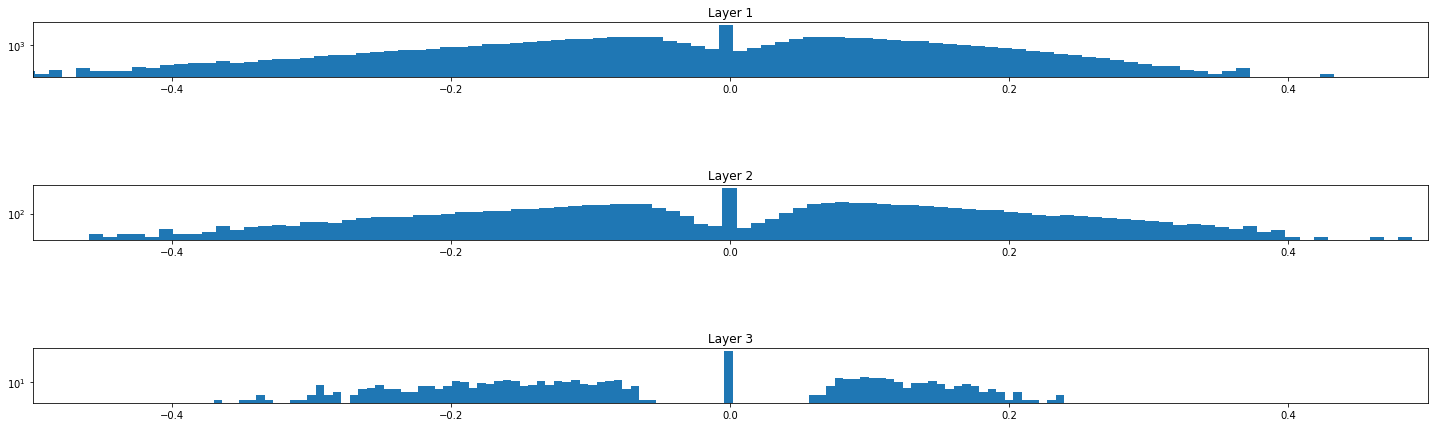

In [340]:
print_weight_hist(pre_pruning_masked_weights[2])

# Weights after Pruning

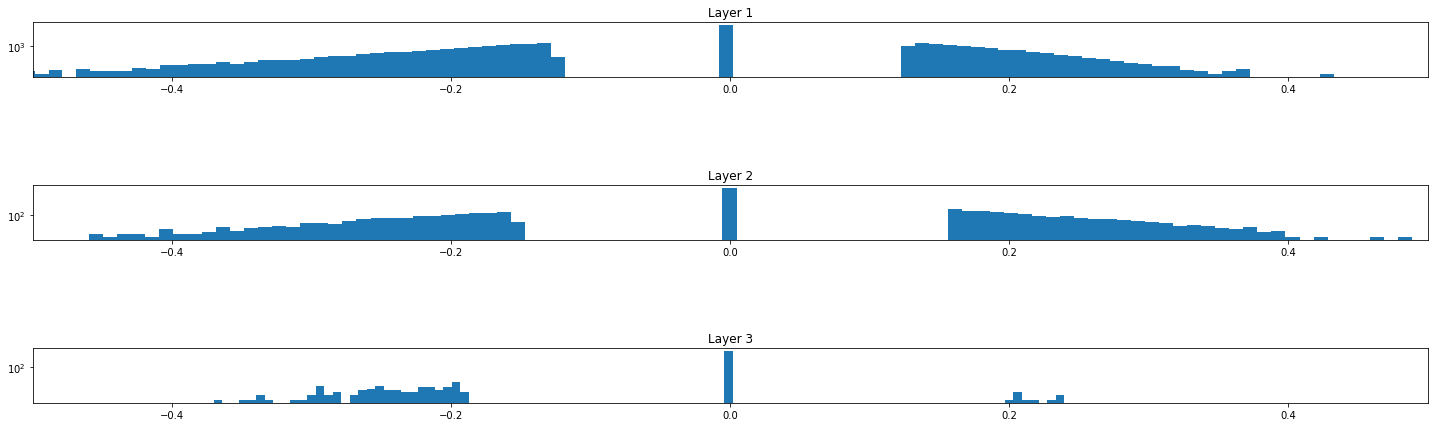

In [341]:
print_weight_hist(post_pruning_masked_weights[2])

# Weights after Fine-tuning

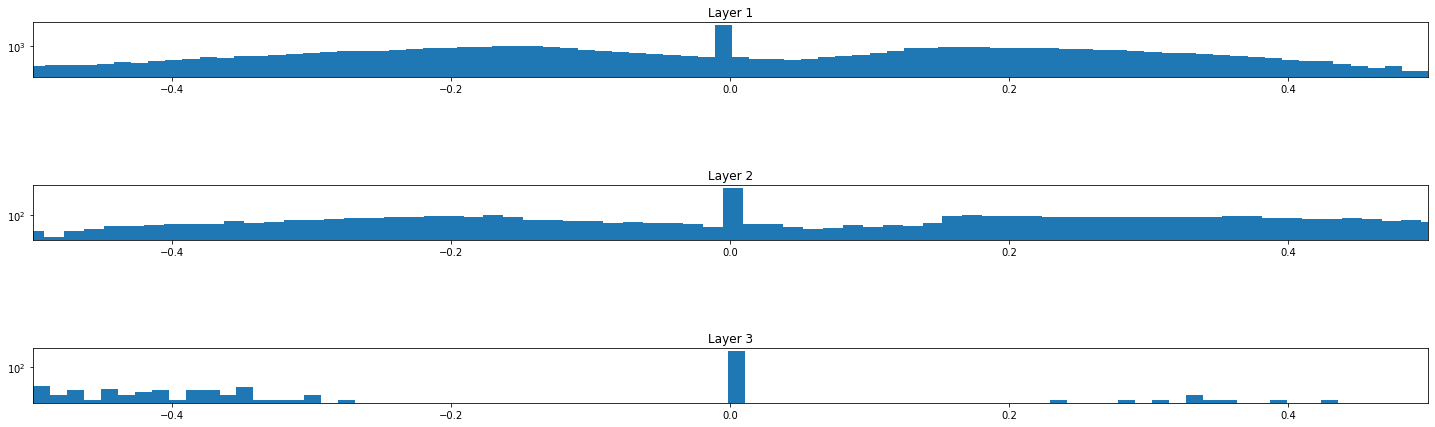

In [342]:
print_weight_hist(post_fine_tuning_masked_weights[2])

# Sanity Tests

In [351]:
with tf.compat.v1.Session() as sess:
    test_model = LeNet300_100()
    test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False

                 )
    test_model.fit(x=x_train[:10000],
              y=y_train[:10000],
              batch_size=64,
              epochs=1,
              validation_data=(x_test, y_test),
              verbose=False
             )
    pruning_ratios = [0.9]
    for pruning_ratio in tqdm(pruning_ratios):
        pruned_weights = prune_weights(test_model, pruning_ratio)
        test_model.set_weights(pruned_weights)
        #print(len([number for number in model.get_weights()[1].flatten() if number == 0]))
        zeros = len([number for number in test_model.get_weights()[1].flatten() if number == 0])+len([number for number in test_model.get_weights()[3].flatten() if number == 0])+len([number for number in test_model.get_weights()[5].flatten() if number == 0])
        total = len(test_model.get_weights()[1].flatten()) + len(test_model.get_weights()[3].flatten()) + len(test_model.get_weights()[5].flatten())
        print('measured pruning ratio = ', zeros/total )
        test_model.fit(x=x_train[:10000],
              y=y_train[:10000],
              batch_size=64,
              epochs=1,
              validation_data=(x_test, y_test),
              verbose=False
             )
    np.set_printoptions(suppress=True)
    #print(model.layers[2].pruned_w.eval().flatten())
    #print(model.layers[2].w.eval().flatten())
    print(test_model.layers[2].pruned_w.eval())


Train on 10000 samples, validate on 10000 samples
10000/10000 [==============================] - 4s 356us/sample - loss: 1.7539 - accuracy: 0.7632 - val_loss: 1.5973 - val_accuracy: 0.8802


  0%|          | 0/1 [00:00<?, ?it/s]

measured pruning ratio =  0.9


100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


[[ 0.         -0.         -0.          0.          0.         -0.
   0.          0.2785092  -0.         -0.        ]
 [-0.3374859  -0.         -0.          0.         -0.          0.
  -0.          0.          0.          0.        ]
 [-0.          0.         -0.          0.          0.          0.
   0.         -0.          0.          0.        ]
 [ 0.         -0.         -0.         -0.         -0.17024063  0.13210315
  -0.          0.          0.          0.        ]
 [ 0.         -0.          0.         -0.         -0.          0.
   0.         -0.24685715  0.         -0.        ]
 [-0.2610079   0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.          0.        ]
 [-0.         -0.         -0.          0.         -0.          0.
  -0.          0.          0.          0.        ]
 [ 0.         -0.         -0.3139406   0.         -0.          0.14136147
   0.          0.         -0.22402331  0.        ]
 [-0.          0.         -0.41287926 -0.       